In [1]:
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import resource
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('scripts/')
import lcwgSus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


In [4]:
df1 = pd.read_csv('data/metadata/seq_info.tsv', sep = '\t')

df2 = pd.read_csv('results/metrics.csv')
df2 = df2.drop(columns = ['Subsample_Uncoverage_0.6x', 'Sequencing_Skew_0.6x', 'Fragment_Size', '% > 500', 'Overlap'])
res = pd.merge(df1, df2, left_on = 'sample', right_on = 'Sample_Name', how = 'inner')
df3 = res.groupby('sample')['count'].sum().reset_index()
res = res[res['run'].str.contains('0753')].drop(columns = ['run', 'ID', 'count'])

res = pd.merge(df3, res, on = 'sample')
ss_uncoverage = pd.read_csv('results/coverage/ss_uncoverage_rate.txt', sep = '\t', header = None, names = ['Code', 'ss_uncoverage'])
uncoverage = pd.read_csv('results/coverage/uncoverage_rate.txt', sep = '\t', header = None, names = ['Code', 'uncoverage'])
coverage = pd.read_csv('results/coverage/per_sample_coverage.txt', sep = '\t', header = None, names = ['Code', 'coverage'])
res = pd.merge(uncoverage, res, on = 'Code')
res = pd.merge(coverage, res, on = 'Code')
res = pd.merge(ss_uncoverage, res, on = 'Code')
res['sequencing skew'] = res['ss_uncoverage']/poisson.pmf(0, mu=0.6, loc=0)
res['effective coverage'] = res['coverage']*(1-res['Dup_Rate'])
# res['skew'] = res['uncoverage']/poisson.pmf(0, mu=res['Coverage'], loc=0)
res['excessive coverage before'] = (res['effective coverage'] - res['uncoverage'])
res['excessive coverage after'] = (0.6 -res['ss_uncoverage'])
res['delta'] = res['excessive coverage before']
# res['loss coverage'] = res['ss_uncoverage'] - res['uncoverage']

df_mini = res[res['Sample_Name'].str.contains('mini')]
df_fv = res[~res['Sample_Name'].str.contains('mini')]
res

,Code,ss_uncoverage,coverage,uncoverage,sample,count,Sample_Name,Dup_Rate,Coverage,Uncoverage,sequencing skew,effective coverage,excessive coverage before,excessive coverage after,delta
0,IDT0481,0.584138,1.2028,0.365355,GM8,13669329,GM8,0.0781,1.1840,0.3936,1.064368,1.108861,0.743507,0.015862,0.743507
1,IDT0482,0.585776,1.1699,0.382538,GM42,13029399,GM42,0.0753,1.1506,0.4103,1.067354,1.081807,0.699268,0.014224,0.699268
2,IDT0483,0.592191,1.1547,0.386672,GM50,13440397,GM50,0.0874,1.1348,0.4140,1.079043,1.053779,0.667107,0.007808,0.667107
3,IDT0484,0.576890,1.2529,0.370430,GM67,13425729,GM67,0.0808,1.2140,0.3995,1.051162,1.151666,0.781235,0.023110,0.781235
4,IDT0485,0.570146,1.4014,0.311429,GM101,15420774,GM101,0.0817,1.3625,0.3437,1.038873,1.286906,0.975477,0.029854,0.975477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,IDT0764,0.563194,1.3244,0.321132,GM872,14319401,GM872,0.0703,1.2995,0.3515,1.026207,1.231295,0.910162,0.036806,0.910162
237,IDT0765,0.566977,1.3208,0.331072,GM1110,14644707,GM1110,0.1008,1.2978,0.3609,1.033099,1.187663,0.856591,0.033023,0.856591
238,IDT0766,0.574483,1.2581,0.347489,GM1114,13952227,GM1114,0.0808,1.2340,0.3762,1.046776,1.156446,0.808957,0.025517,0.808957
239,IDT0767,0.569650,1.2904,0.336797,GM1117,14081550,GM1117,0.0755,1.2713,0.3666,1.037971,1.192975,0.856177,0.030350,0.856177


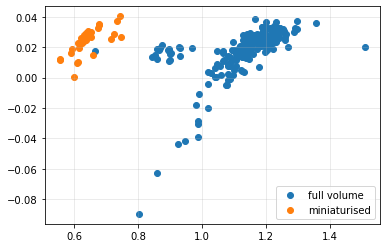

In [6]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['excessive coverage after'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['excessive coverage after'], label = 'miniaturised')
# ax.set_xlabel('Effective genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

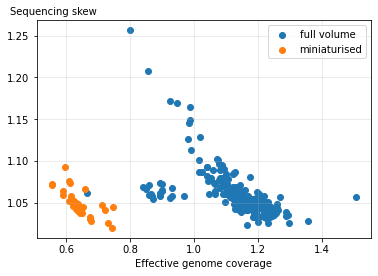

In [55]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Effective genome coverage')
ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

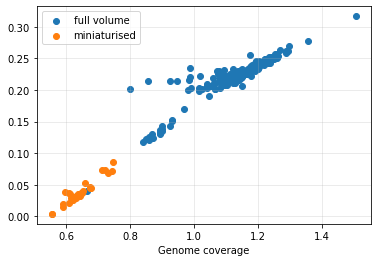

In [42]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['loss coverage'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['loss coverage'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

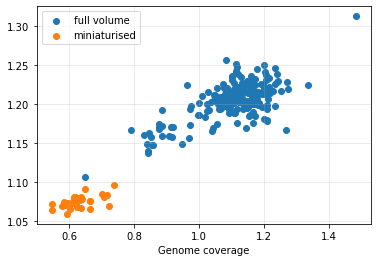

In [13]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['skew'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['skew'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

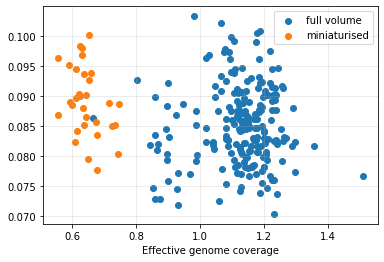

In [54]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['Dup_Rate'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['Dup_Rate'], label = 'miniaturised')
ax.set_xlabel('Effective genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

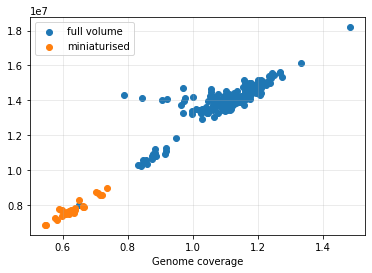

In [16]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['count'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['count'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

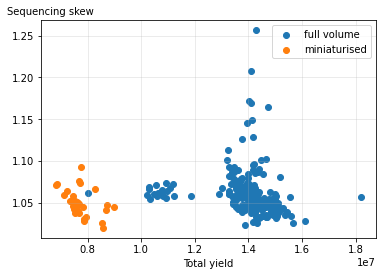

In [51]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['count'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['count'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Total yield')
ax.text(x = 0.5e7, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

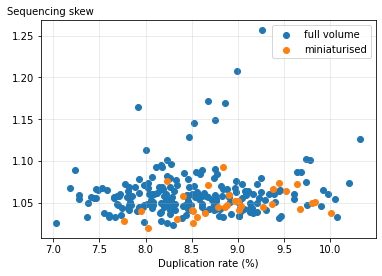

In [53]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['Dup_Rate']*100, df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['Dup_Rate']*100, df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Duplication rate (%)')
ax.text(x = 6.5, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

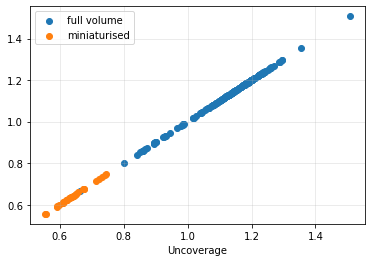

In [44]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter((df_fv['effective coverage']), df_fv['excessive coverage'], label = 'full volume')
ax.scatter((df_mini['effective coverage']), df_mini['excessive coverage'], label = 'miniaturised')
ax.set_xlabel('Uncoverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)